# Assignment 4
## Training a DNN for relation classification

In this assignment you are required to build a full training and testing pipeline for a neural relation classification (RC), using BERT.


**In this work we will use the hugingface framework for transformers training and inference.**
We recomand reading the documentation in [this](https://huggingface.co/docs/transformers/main/en/model_doc/bert#transformers.BertForSequenceClassification) link *before* you start coding.


All additional packages:

In [3]:
# !pip install --q
# %pip install --q transformers

All imports: (You may add/change)

In [4]:
# general
import os
import random
import warnings
from typing import List,Tuple
import pickle


# ML
import numpy as np
import scipy as sp
import pandas as pd

# visual
import matplotlib
import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display

# DL
import torch
import torch.nn as nn

# HF
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AutoModel

Set warnings filter to ignore:

In [5]:
# set warnings filter to ignore:
warnings.filterwarnings("ignore")

Set random SEEDs:

In [6]:
# set random SEEDs:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Set GPU:

In [7]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'
print(f'Using {DEVICE} device')

Using cuda device


## Dataset


The dataset that you will be working on is called SemEval Task 8 dataset (https://arxiv.org/pdf/1911.10422v1.pdf).
The dataset contain only train and test split, but you are allowed to split the train dataset into dev if needed.


The two files (train and test) are available from the course git repository (https://github.com/kfirbar/nlp-course)

> Train file: `nlp-course/TRAIN_FILE.TXT`
> Test file: `nlp-course/TEST_FILE_FULL.TXT`


In [8]:
# !git clone https://github.com/kfirbar/nlp-course

## Task #1

Write a funtion `read_data` for reading the data from a single file (either train or test).

<br>

This function recieves a filepath and returns a list of sentences; Every sentence is encoded as a tuple.

The first element is the sentence string.
The second element is the label (also represented as a sting).

In [9]:
import re
from typing import List, Tuple

def read_data(filepath: str, remove_e1_e2_from_label: bool = True) -> List[Tuple[str, str]]:
    data = []
    with open(filepath, 'r') as file:
        lines = file.readlines()
        for i in range(0, len(lines), 4): # 4 lines per sample
            sentence = re.findall(r'"([^"]*)"', lines[i])[0]
            label = lines[i+1].strip()
            # remove (e1,e2) from label
            if remove_e1_e2_from_label:
                label = label.replace('(e1,e2)', '').replace('(e2,e1)', '').strip()
            data.append((sentence, label))
    return data

# Define filepaths for your train and test data
train_filepath = "nlp-course/TRAIN_FILE.TXT"
test_filepath = "nlp-course/TEST_FILE_FULL.TXT"
# Read the data (tuple of (sentence, label)
train = read_data(train_filepath)
test = read_data(test_filepath)
# Convert to pandas dataframe
train_df = pd.DataFrame(train, columns=['sentence', 'label'])
test_df = pd.DataFrame(test, columns=['sentence', 'label'])

print('Number of train sentences:', len(train))
print('Number of test sentences:', len(test))


Number of train sentences: 8000
Number of test sentences: 2717


In [10]:
# print some examples
print('Train examples:')
display(train_df.sample(5))
print('Test examples:')
display(test_df.sample(5))


Train examples:


,sentence,label
2215,The inhabitants send messages to each other by...,Entity-Destination
2582,I placed the <e1>cache</e1> in a natural <e2>c...,Entity-Destination
1662,"Since then, millions of <e1>dollars</e1> have ...",Other
3027,Lavender is excellent in the reatment of <e1>h...,Cause-Effect
4343,A <e1>gunman</e1> pumped a bullet into his rig...,Other


Test examples:


,sentence,label
1012,A metal pipe connects the magnetron to the coo...,Component-Whole
2279,The popular <e1>soap</e1> has been moved to <e...,Entity-Destination
2548,All of the <e1>products</e1> grown by the <e2>...,Product-Producer
1183,I maintained an even temperature in my ward by...,Content-Container
2670,The <e1>book</e1> has made a significant contr...,Other


`Pytorch` require the labels to be integers.

Create a mapper (dictionary) from the string labels to integers (starting zero).
And a dictionary from label to integer.

In [11]:
def create_label_mapper(data):
  # create a dictionary that maps each id to a label
  id2label = {}
  label2id = {}
  unique_labels = data['label'].unique()
  for i, label in enumerate(unique_labels):
    id2label[i] = label
    label2id[label] = i
  return id2label, label2id



# TO DO
id2label, label2id = create_label_mapper(train_df)

assert len(id2label) == len(label2id)
print('id2label: \n',id2label)

id2label: 
 {0: 'Component-Whole', 1: 'Other', 2: 'Instrument-Agency', 3: 'Member-Collection', 4: 'Cause-Effect', 5: 'Entity-Destination', 6: 'Content-Container', 7: 'Message-Topic', 8: 'Product-Producer', 9: 'Entity-Origin'}


<br>

Plot the distribution of labels in each dataset.
Display the information in a single plot.

For example:

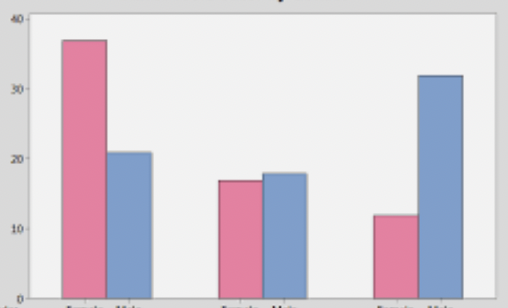

- Use bar plot.
- Use figuresize of (16,6).
- Add titles and Axis names.
- Y-axis will hold the count for each label.
- X-axis will hold the name of each label.

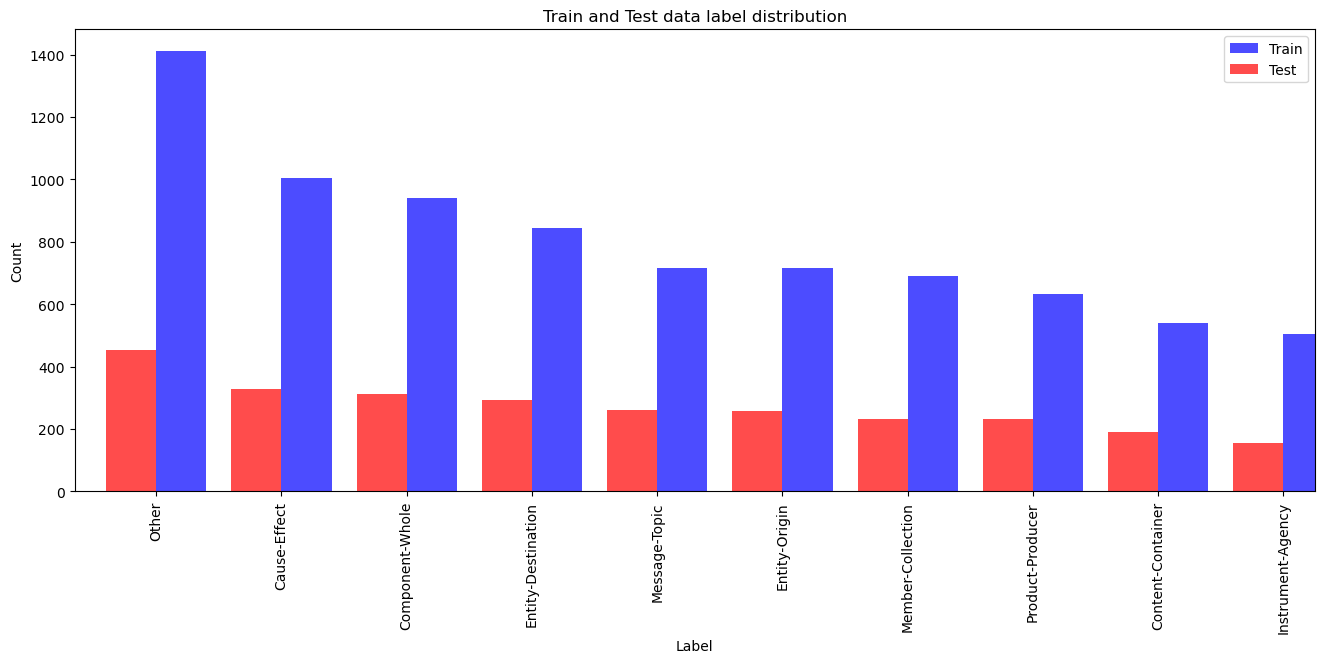

In [12]:
# plot the label distribution in each dataset

# function to plot the distribution of labels in each dataset
def plot_label_distribution(train_data, test_data, title):
    # make a copy of the data so we won't change the original dataframe
    train_data_copy = train_data.copy()
    test_data_copy = test_data.copy()

    # create a figure and axis object
    fig, ax = plt.subplots(figsize=(16, 6))
    # plot the count of each label in the train and test dataset
    train_data_copy['label'].value_counts().plot(kind='bar', ax=ax, color='blue', alpha=0.7, label='Train', position=0, width=0.4)
    test_data_copy['label'].value_counts().plot(kind='bar', ax=ax, color='red', alpha=0.7, label='Test', position=1, width=0.4)

    # set the x and y axis labels and title
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    ax.set_title(title)
    # plot the legend and show the plot
    ax.legend() 
    plt.show()
    # return the unique labels in the train
    return train_data_copy['label'].unique()
    
# call the function to plot the label distribution in the train and test datasets
train_labels = plot_label_distribution(train_df, test_df, 'Train and Test data label distribution')


<br>

<br><br><br><br>


## Task #2

Download the relevant BERT tokenizer.
Use `bert-base-uncased` .


In [13]:
# TODO
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [14]:
# TODO: Delete this cell before submitting the notebook, just for testing

# Define a sentence to tokenize
sentence = "The quick brown fox jumps over the lazy dog."

# Tokenize the sentence using the tokenizer
tokens = tokenizer.encode(sentence)
decoded_tokens = tokenizer.decode(tokens)

# Print the token IDs and corresponding tokens
print("Token IDs:", tokens)
print("Tokens:", decoded_tokens.split())

Token IDs: [101, 1996, 4248, 2829, 4419, 14523, 2058, 1996, 13971, 3899, 1012, 102]
Tokens: ['[CLS]', 'the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog.', '[SEP]']


In [15]:
# tokenize the first sentence in the train dataset
tokens = tokenizer.encode('<e1> </e1> <e2></e2>')
decoded_tokens = tokenizer.decode(tokens)
token_list = decoded_tokens.split()
print("Token IDs:", tokens)
print("Tokens:", token_list)


Token IDs: [101, 1026, 1041, 2487, 1028, 1026, 1013, 1041, 2487, 1028, 1026, 1041, 2475, 1028, 1026, 1013, 1041, 2475, 1028, 102]
Tokens: ['[CLS]', '<', 'e1', '>', '<', '/', 'e1', '>', '<', 'e2', '>', '<', '/', 'e2', '>', '[SEP]']


Write a function `prepare_data` that takes one of the `train & test` datasets and convert each pair of `(words,labels)` to a pair of indexes.

The function also aggregate the samples into batches.

BERT Uses pretrained tokanization and embedding.
you can access the tokanization and indexing using the `BertTokenizer` class.

Note: you may use `torch.utils.data.Dataset`

In [16]:
import torch.utils.data as data_utils
#TODO: check about aggragte into batches

# given a dataframe of (sentence, label) columns, returns a list of (tokenized sentence, label_id) tuples
def prepare_data(data, tokenizer, batch_size=8):
    data_sequences = [(tokenizer.encode(sentence), label2id[label]) for sentence, label in data]
    return data_sequences

train_sequences = prepare_data(train, tokenizer)
test_sequences = prepare_data(test, tokenizer)

train_sequences_df = pd.DataFrame(train_sequences, columns=['tokens', 'label_id'])
test_sequences_df = pd.DataFrame(test_sequences, columns=['tokens', 'label_id'])

In [17]:
# print some examples
print('Train examples:')
display(train_sequences_df.sample(5))
print('Test examples:')
display(test_sequences_df.sample(5))

Train examples:


,tokens,label_id
5241,"[101, 1996, 1026, 1041, 2487, 1028, 4680, 1026...",1
6349,"[101, 2002, 10415, 16429, 18908, 2121, 1052, 8...",5
963,"[101, 1996, 2566, 10196, 3372, 1026, 1041, 248...",7
1539,"[101, 1996, 1026, 1041, 2487, 1028, 8659, 1026...",0
7611,"[101, 2026, 3291, 2003, 2008, 1996, 1026, 1041...",4


Test examples:


,tokens,label_id
287,"[101, 2023, 2003, 2028, 1997, 1996, 2062, 2691...",4
1067,"[101, 2172, 2066, 1996, 1026, 1041, 2487, 1028...",4
816,"[101, 1996, 2224, 1997, 8045, 4275, 1998, 1597...",3
2697,"[101, 1996, 1026, 1041, 2487, 1028, 7006, 7971...",1
1165,"[101, 2023, 1026, 1041, 2487, 1028, 3698, 1026...",0


In [18]:
# Import the pad_sequence function from PyTorch to pad sequences to the same length
from torch.nn.utils.rnn import pad_sequence

# Convert the data to PyTorch DataLoader objects
train_dataset = data_utils.TensorDataset(
    # Pad the sequences in the 'tokens' column of the train_sequences_df DataFrame and convert them to PyTorch tensors
    pad_sequence([torch.tensor(seq) for seq in train_sequences_df['tokens'].tolist()], batch_first=True),
    # Convert the 'label_id' column of the train_sequences_df DataFrame to a PyTorch tensor
    torch.tensor(train_sequences_df['label_id'].tolist())
)

test_dataset = data_utils.TensorDataset(
    # Pad the sequences in the 'tokens' column of the test_sequences_df DataFrame and convert them to PyTorch tensors
    pad_sequence([torch.tensor(seq) for seq in test_sequences_df['tokens'].tolist()], batch_first=True),
    # Convert the 'label_id' column of the test_sequences_df DataFrame to a PyTorch tensor
    torch.tensor(test_sequences_df['label_id'].tolist())
)

# split the train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = data_utils.random_split(train_dataset, [train_size, val_size])

# create the dataloaders
train_dataloader = data_utils.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = data_utils.DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = data_utils.DataLoader(test_dataset, batch_size=16, shuffle=False)


In [19]:
# test the dataloaders
for batch in train_dataloader:
    input_ids, labels = batch
    print('Input IDs shape:', input_ids.shape)
    print('Labels shape:', labels.shape)
    break


Input IDs shape: torch.Size([16, 141])
Labels shape: torch.Size([16])


<br><br><br><br>

## Task #3

In this part we classify the sentences using the `BertForSequenceClassification` model.


Download the relevant BERT model. Use `bert-base-uncased` .

In [20]:
# TO DO

model_part3 = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(id2label)).to(DEVICE)




Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [21]:
# print model layers
print('Model layers:')
for name, param in model_part3.named_parameters():
    print(f'{name} has shape {param.shape}')
    
    

Model layers:
bert.embeddings.word_embeddings.weight has shape torch.Size([30522, 768])
bert.embeddings.position_embeddings.weight has shape torch.Size([512, 768])
bert.embeddings.token_type_embeddings.weight has shape torch.Size([2, 768])
bert.embeddings.LayerNorm.weight has shape torch.Size([768])
bert.embeddings.LayerNorm.bias has shape torch.Size([768])
bert.encoder.layer.0.attention.self.query.weight has shape torch.Size([768, 768])
bert.encoder.layer.0.attention.self.query.bias has shape torch.Size([768])
bert.encoder.layer.0.attention.self.key.weight has shape torch.Size([768, 768])
bert.encoder.layer.0.attention.self.key.bias has shape torch.Size([768])
bert.encoder.layer.0.attention.self.value.weight has shape torch.Size([768, 768])
bert.encoder.layer.0.attention.self.value.bias has shape torch.Size([768])
bert.encoder.layer.0.attention.output.dense.weight has shape torch.Size([768, 768])
bert.encoder.layer.0.attention.output.dense.bias has shape torch.Size([768])
bert.encoder


Write a function `get_parameters` that gets the model as an input and return the top(final) layer of the model for a `torch` optimizer.

Note: take a look at these links [link1](https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6#:~:text=%3E%3E%3E-,for%20name%2C%20para%20in%20net.named_parameters()%3A,-...%20%20%20%20%20para.requires_grad%20%3D%20False) [link2](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) .


In [22]:
# # given a model parameters, returns the parameters of the top (final) layer and the layer before it
# def get_top_layer_parameters(params):
#     top_layer_params = []
#     for name, param in params:
#         if 'classifier' in name: # classifier layer, i.e. the top layer
#             top_layer_params.append(param)
#             break
#         elif 'pooler' in name:
#             top_layer_params.append(param)
#         elif 'layer.11' in name:
#             top_layer_params.append(param)
#     return top_layer_params

# all_model_params = model.named_parameters()
# top_layer_params = get_top_layer_parameters(all_model_params)

# TODO: can delete this cell, downer cell is the one to use


In [23]:
# better version of get_top_layer_parameters
def get_layer_parameters(named_params, layer_names):
    layer_params = [param for name, param in named_params if any(layer_name in name for layer_name in layer_names)]
    return layer_params

layer_names = ['classifier', 'pooler', 'layer.11']
all_model_params = model_part3.named_parameters()
top_layer_params = get_layer_parameters(all_model_params, layer_names)


In [24]:
# set requires_grad to False for all parameters except the top layer
for name, param in model_part3.named_parameters():
    param.requires_grad = False

for param in top_layer_params:
    param.requires_grad = True

print('Parameters that will be updated:') 
for name, param in model_part3.named_parameters():
    if param.requires_grad:
        print(name)

Parameters that will be updated:
bert.encoder.layer.11.attention.self.query.weight
bert.encoder.layer.11.attention.self.query.bias
bert.encoder.layer.11.attention.self.key.weight
bert.encoder.layer.11.attention.self.key.bias
bert.encoder.layer.11.attention.self.value.weight
bert.encoder.layer.11.attention.self.value.bias
bert.encoder.layer.11.attention.output.dense.weight
bert.encoder.layer.11.attention.output.dense.bias
bert.encoder.layer.11.attention.output.LayerNorm.weight
bert.encoder.layer.11.attention.output.LayerNorm.bias
bert.encoder.layer.11.intermediate.dense.weight
bert.encoder.layer.11.intermediate.dense.bias
bert.encoder.layer.11.output.dense.weight
bert.encoder.layer.11.output.dense.bias
bert.encoder.layer.11.output.LayerNorm.weight
bert.encoder.layer.11.output.LayerNorm.bias
bert.pooler.dense.weight
bert.pooler.dense.bias
classifier.weight
classifier.bias


Define the optimizer:

- Use the `ADAM` optimizer (from `torch.optim`), which is a fancy version of SGD.
- Use a learning rate of 0.0001.
- Send only the top/final layer of the model to the optimizer (use `top_layer_params`).


In [25]:
# TO DO
optimizer = torch.optim.Adam(top_layer_params, lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

<br><br><br><br>

## Task #4

Let's create the trainig function!


1. Write a training function, which takes a the model `BertForSequenceClassification` and number of epochs to train on.

2. Set `criterion` to the `CrossEntropyLoss` (from `torch.nn`) and use the `ADAM` optimizer.

3. Use a simple `for` loop to iterate over the epochs.
Use [tqdm](https://github.com/tqdm/tqdm) to mark your iteration and progress.

Notes:
- You may to split the `train` to `train&dev` sets.
- You may change the input/output of the training function.


In [26]:
def training(model, n_epochs, train_dataloader, dev_dataloader, optimizer, criterion):
    model.train()
    # history variables
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in tqdm(range(n_epochs)):
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0

        # training
        for batch in train_dataloader:
            sentences, labels = batch
            sentences = sentences.to(DEVICE)
            labels = labels.to(DEVICE)
            # forward pass
            optimizer.zero_grad()
            outputs = model.forward(sentences)
            loss = criterion(outputs.logits, labels)
            # backward pass
            loss.backward()
            optimizer.step()
            # update loss and acc variables
            train_loss += loss.item()
            _, preds = torch.max(outputs.logits, dim=1)
            train_acc += torch.sum(preds == labels).item()
        # validation
        for batch in dev_dataloader:
            sentences, labels = batch
            sentences = sentences.to(DEVICE)
            labels = labels.to(DEVICE)
            with torch.no_grad():
                outputs = model.forward(sentences)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs.logits, dim=1)
                val_acc += torch.sum(preds == labels).item()
                
        # calculate average loss and accuracy
        train_loss = train_loss / len(train_dataloader)
        val_loss = val_loss / len(dev_dataloader)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc = train_acc / len(train_dataloader.dataset)
        val_acc = val_acc / len(dev_dataloader.dataset)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        # print progress at the end of each epoch
        print('Epoch: {}/{}, Train Loss: {:.4f}, Val Loss: {:.4f}, Train Acc: {:.4f}, Val Acc: {:.4f}'.format(
            epoch + 1, n_epochs, train_loss, val_loss, train_acc, val_acc))
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history


In [27]:
# # train the model
# train_loss_history, val_loss_history, train_acc_history, val_acc_history = training(model_part3, 20, train_dataloader, val_dataloader, optimizer, loss_fn)

# # save the model, train and validation history
# torch.save(model_part3.state_dict(), 'model_part_4.pth')
# torch.save({
#     'train_loss_history': train_loss_history,
#     'val_loss_history': val_loss_history,
#     'train_acc_history': train_acc_history,
#     'val_acc_history': val_acc_history
# }, 'model_part_4_history.pth')


In [28]:
# load the model
model_part3.load_state_dict(torch.load('model_part_4.pth'))
# load the train and validation history
checkpoint = torch.load('model_part_4_history.pth')
train_loss_history = checkpoint['train_loss_history']
val_loss_history = checkpoint['val_loss_history']
train_acc_history = checkpoint['train_acc_history']
val_acc_history = checkpoint['val_acc_history']

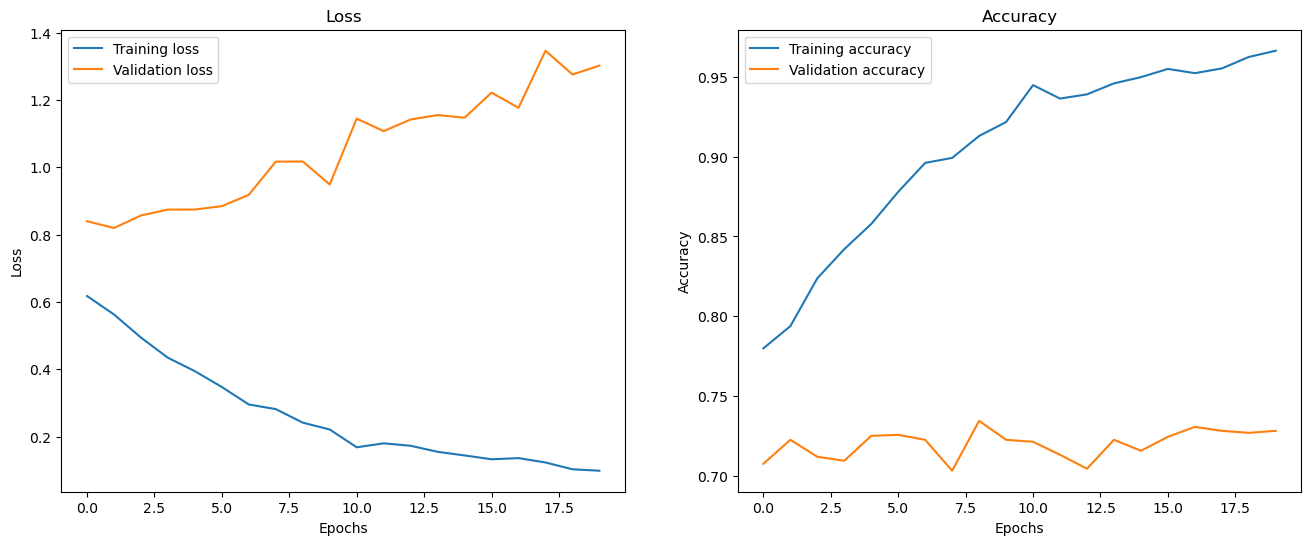

In [29]:
import matplotlib.pyplot as plt

# plot the training and validation loss
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(train_loss_history, label='Training loss')
axs[0].plot(val_loss_history, label='Validation loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# plot the training and validation accuracy
axs[1].plot(train_acc_history, label='Training accuracy')
axs[1].plot(val_acc_history, label='Validation accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()



<br><br><br><br>

## Task #5

Write an evaluation loop on a trained model, using the test dataset.

Instructions:
> Input: model, data
> Output: Report, Confusion matrix

> 1. Display: Report, Confusion matrix
> 2. Save: a csv report


Explanation:
This function will perform an evaluation over a model with a dataset.
Calculate the `PERCISION, RECALL, F1` scores of each label seperately, and display them in a table.

Display a confusion matrix plot: where the predicted labels are the rows, and the true labels are the columns.


In addition, load thwe report to a dataframe and save to a CSV with this name:

> `{student_id_1}_{student_id_n}_part5.csv`
For example: `300123123_200456789_part_5.csv`



In [30]:
from sklearn.metrics import classification_report, confusion_matrix


#cols   = ['PERCISION','RECALL','F1','SUPPORT']
# old labels, not used (this is 10, we have 19)
labels_OG = ['Other', 'Cause-Effect', 'Component-Whole', 'Content-Container', 'Entity-Destination', 'Entity-Origin', 'Instrument-Agency', 'Member-Collection', 'Message-Topic', 'Product-Producer']


# given model and test data, return Report (Persicion, Recall, F1, Support) and Confusion Matrix
def evaluate(model, test_dataloader):
  model.eval()
  y_true = []
  y_pred = []
  with torch.no_grad():
    for batch in test_dataloader:
      sentences, labels = batch
      sentences = sentences.to(DEVICE)
      labels = labels.to(DEVICE)
      outputs = model(sentences)
      _, preds = torch.max(outputs.logits, dim=1)
      preds = preds.tolist()
      labels = labels.tolist()
      y_true.extend(labels)
      y_pred.extend(preds)

  return y_pred, y_true   



# evaluate the model on the test data
y_pred , y_true = evaluate(model_part3, test_dataloader)


In [31]:

def get_report(y_pred, y_true, labels):
  report = classification_report(y_true, y_pred, output_dict=True, labels=labels)
  report = pd.DataFrame(report).transpose()
  report = report.loc[labels][['precision', 'recall', 'f1-score']]
  return report

def get_cm_matrix(y_pred, y_true, labels):
  matrix = confusion_matrix(y_true, y_pred, labels=labels)
  matrix = pd.DataFrame(matrix, index=labels, columns=labels).transpose() # rows are predicted, columns are actual
  return matrix

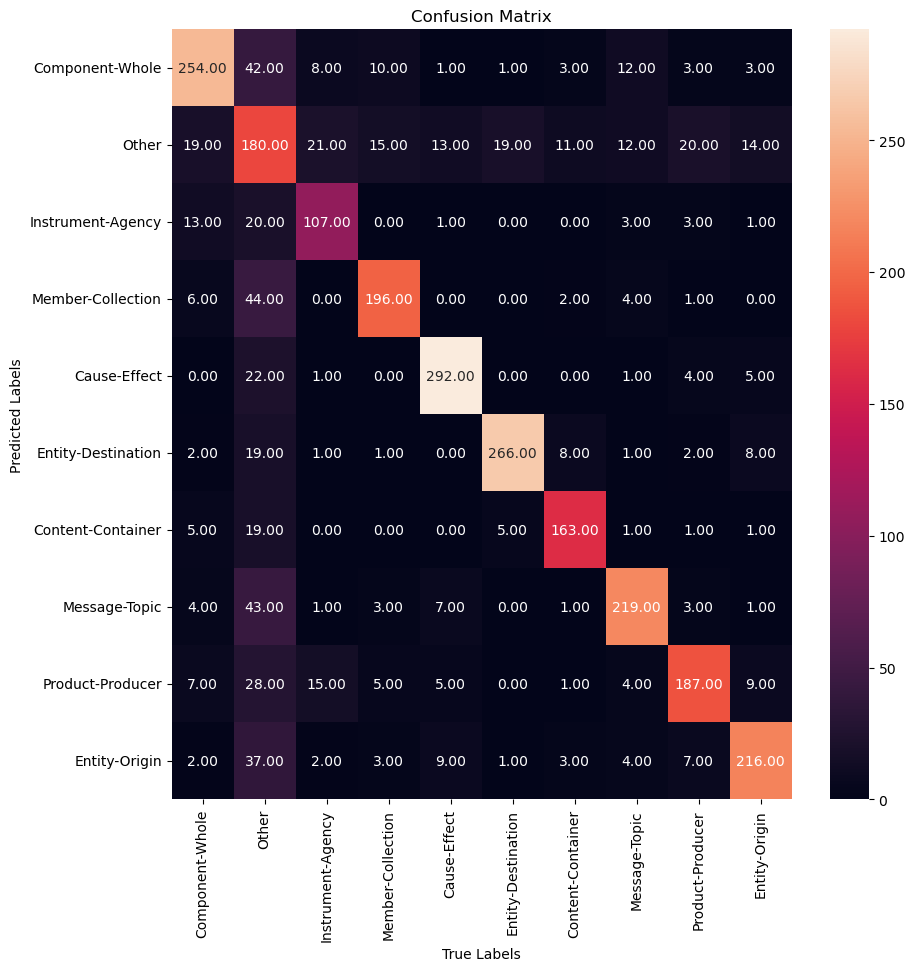

+--------------------+-------------+----------+------------+
|                    |   precision |   recall |   f1-score |
|--------------------+-------------+----------+------------|
| Component-Whole    |    0.753709 | 0.814103 |   0.782743 |
| Other              |    0.555556 | 0.396476 |   0.462725 |
| Instrument-Agency  |    0.722973 | 0.685897 |   0.703947 |
| Member-Collection  |    0.774704 | 0.841202 |   0.806584 |
| Cause-Effect       |    0.898462 | 0.890244 |   0.894334 |
| Entity-Destination |    0.863636 | 0.910959 |   0.886667 |
| Content-Container  |    0.835897 | 0.848958 |   0.842377 |
| Message-Topic      |    0.776596 | 0.83908  |   0.80663  |
| Product-Producer   |    0.716475 | 0.809524 |   0.760163 |
| Entity-Origin      |    0.760563 | 0.837209 |   0.797048 |
+--------------------+-------------+----------+------------+


In [32]:
# convert the label_ids to labels_str
y_pred_str = [id2label[i] for i in y_pred]
y_true_str = [id2label[i] for i in y_true]

# compute confusion matrix
cm_matrix = get_cm_matrix(y_pred_str, y_true_str, list(label2id.keys()))
# plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm_matrix, annot=True, fmt='.2f')
plt.title('Confusion Matrix')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

# compute classification report
report = get_report(y_pred_str, y_true_str, list(label2id.keys()))
print(tabulate(report, headers='keys', tablefmt='psql'))


<br><br><br><br>

## Task #6

In this part we'll improve the model accuracy by using a method called "entity markers - Entity start".

The main idea of this approch is to add special markers ([e1], [\e1], ...) before and after each of the tagged entities. Instead of using the `CLS token` for clasification, we will use the concatination of the embedding of `[e1]` and `[e2]` as shown in the image below.

The complete method is described in details in the paper [Matching the Blanks: Distributional Similarity for Relation Learning following](https://arxiv.org/pdf/1906.03158.pdf) (specifically in Section 3.2).

 To use this method we'll need to create a new data load and a new model.

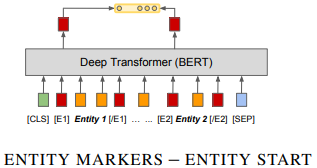

The new methods require the usage of special tokens.
Fix the following code so it will add the required tokens:

In [33]:
E1_START = '<e1>'
E1_END   = '</e1>'
E2_START = '<e2>'
E2_END   = '</e2>'

# clear all cuda memory
DEVICE = 'cpu'

# TO DO
new_tokens = [E1_START, E1_END, E2_START, E2_END]
mtb_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
mtb_tokenizer.add_tokens(new_tokens)

4

Create a new dataloader that add entity markers to the dataset and return their indexes as part of the new sample (the expected sample should be (s, l, i) where s is the sentence embedding, l is the label, and i is a touple with the indexes of the start entities)

Note: you may change the classes, function, etc.

In [34]:
## read the data without removing the entity markers

# Define filepaths for your train and test data
train_filepath = "nlp-course/TRAIN_FILE.TXT"
test_filepath = "nlp-course/TEST_FILE_FULL.TXT"
# Read the data (tuple of (sentence, label)
train_with_entity_markers = read_data(train_filepath, remove_e1_e2_from_label=False)
test_with_entity_markers = read_data(test_filepath, remove_e1_e2_from_label=False)
# Convert to pandas dataframe
train_df_with_entity_markers = pd.DataFrame(train_with_entity_markers, columns=['sentence', 'label'])
test_df_with_entity_markers = pd.DataFrame(test_with_entity_markers, columns=['sentence', 'label'])

print('Number of train sentences:', len(train_with_entity_markers))
print('Number of test sentences:', len(test_with_entity_markers))

# print the first 5 rows of the train dataframe
train_df_with_entity_markers.head()

# print random 5 rows of the train dataframe
train_df_with_entity_markers.sample(5)



Number of train sentences: 8000
Number of test sentences: 2717


,sentence,label
395,Villagers in the Netherlands are glad to have ...,"Member-Collection(e2,e1)"
2433,But O'Brien was proud of how his <e1>team</e1>...,Other
2920,The <e1>protein</e1> migrated into the <e2>nuc...,"Entity-Destination(e1,e2)"
2787,I remember one day many years ago sitting on t...,"Member-Collection(e2,e1)"
962,A first <e1>revolution</e1> was triggered by t...,"Cause-Effect(e2,e1)"


In [35]:
# class MTBRCDataset(torch.utils.data.Dataset):
#   def __init__(self, data):
#     super(MTBRCDataset, self).__init__()
#     pass


In [36]:
id2label_with_entity_markers, label2id_with_entity_markers = create_label_mapper(train_df_with_entity_markers)
print('label2id:', label2id_with_entity_markers)
print('id2label:', id2label_with_entity_markers)

label2id: {'Component-Whole(e2,e1)': 0, 'Other': 1, 'Instrument-Agency(e2,e1)': 2, 'Member-Collection(e1,e2)': 3, 'Cause-Effect(e2,e1)': 4, 'Entity-Destination(e1,e2)': 5, 'Content-Container(e1,e2)': 6, 'Message-Topic(e1,e2)': 7, 'Product-Producer(e2,e1)': 8, 'Member-Collection(e2,e1)': 9, 'Entity-Origin(e1,e2)': 10, 'Cause-Effect(e1,e2)': 11, 'Component-Whole(e1,e2)': 12, 'Message-Topic(e2,e1)': 13, 'Product-Producer(e1,e2)': 14, 'Entity-Origin(e2,e1)': 15, 'Content-Container(e2,e1)': 16, 'Instrument-Agency(e1,e2)': 17, 'Entity-Destination(e2,e1)': 18}
id2label: {0: 'Component-Whole(e2,e1)', 1: 'Other', 2: 'Instrument-Agency(e2,e1)', 3: 'Member-Collection(e1,e2)', 4: 'Cause-Effect(e2,e1)', 5: 'Entity-Destination(e1,e2)', 6: 'Content-Container(e1,e2)', 7: 'Message-Topic(e1,e2)', 8: 'Product-Producer(e2,e1)', 9: 'Member-Collection(e2,e1)', 10: 'Entity-Origin(e1,e2)', 11: 'Cause-Effect(e1,e2)', 12: 'Component-Whole(e1,e2)', 13: 'Message-Topic(e2,e1)', 14: 'Product-Producer(e1,e2)', 15: '

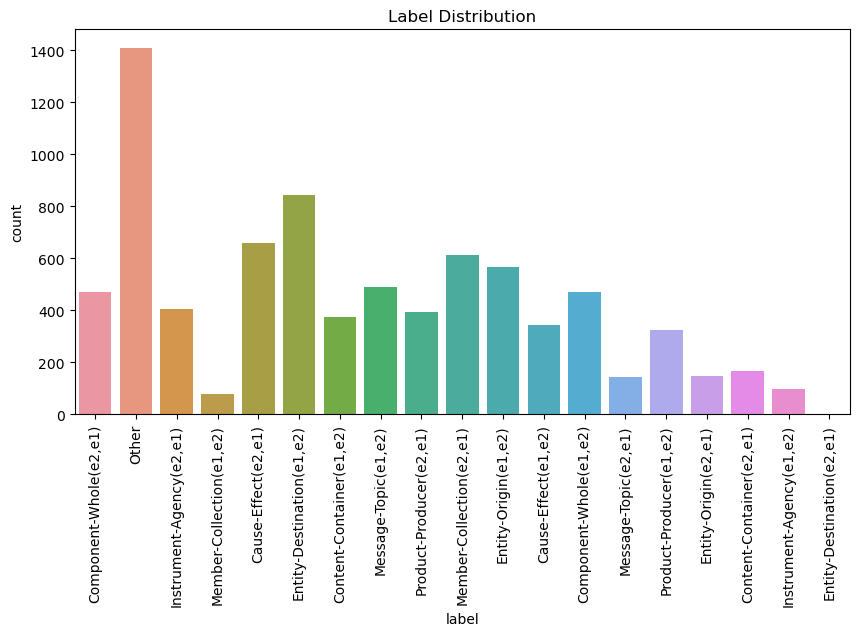

In [37]:
# plot label distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=train_df_with_entity_markers)
plt.title('Label Distribution')
plt.xticks(rotation=90) # rotate x-axis labels by 90 degrees
plt.show()


In [38]:
# given a dataframe with sentence and label columns, returns a list of tuples (token_ids, label_id, index-tuple) s.t index-tuple = (e1_start, e1_end, e2_start, e2_end)
def prepare_data_MTB(data, tokenizer, batch_size=8):
    count = 0
    total = len(data)
    sequences = []
    # iterate over the data (dataframe with columns: sentence, label)
    for index, row in data.iterrows():
        sentence = row['sentence']
        label = row['label']
        # tokenize the sentence
        tokens = tokenizer.tokenize(sentence)
        # find the index of the entity markers
        if E1_START in tokens and E1_END in tokens and E2_START in tokens and E2_END in tokens:
            e1_start = tokens.index(E1_START)
            e1_end = tokens.index(E1_END)
            e2_start = tokens.index(E2_START)
            e2_end = tokens.index(E2_END)
            # convert the labels to label_ids
            label_id = label2id_with_entity_markers[label]
            # convert the tokens to token_ids
            token_ids = tokenizer.convert_tokens_to_ids(tokens)
            # add the token_ids, label_id and index-tuple to the list of sequences
            sequences.append((token_ids, label_id, (e1_start, e1_end, e2_start, e2_end)))
        else:
            count += 1
            #print('Entity markers not found in sentence:', sentence)

    print("number of sentences without entity markers:", count, "out of", total)
    return sequences

train_sequences_with_entity_markers = prepare_data_MTB(train_df_with_entity_markers, mtb_tokenizer, batch_size=16)
test_sequences_with_entity_markers = prepare_data_MTB(test_df_with_entity_markers, mtb_tokenizer, batch_size=16)

train_sequences_df_with_entity_markers = pd.DataFrame(train_sequences_with_entity_markers, columns=['tokens', 'label_id', 'index_tuple'])
test_sequences_df_with_entity_markers = pd.DataFrame(test_sequences_with_entity_markers, columns=['tokens', 'label_id', 'index_tuple'])

number of sentences without entity markers: 75 out of 8000
number of sentences without entity markers: 35 out of 2717


In [39]:
# print the first 5 rows of the train dataframe
print(train_sequences_df_with_entity_markers.head())

# print length of train and test sequences
print('Number of train sequences:', len(train_sequences_with_entity_markers))
print('Number of test sequences:', len(test_sequences_with_entity_markers))

                                              tokens  label_id   
0  [1996, 2291, 2004, 2649, 2682, 2038, 2049, 460...         0  \
1  [1996, 30522, 2775, 30523, 2001, 5362, 5058, 1...         1   
2  [1996, 30522, 3166, 30523, 1997, 1037, 3145, 6...         2   
3  [1037, 15167, 30522, 5526, 30523, 2039, 29346,...         1   
4  [1996, 30522, 3076, 30523, 30524, 2523, 30525,...         3   

        index_tuple  
0  (13, 15, 18, 20)  
1    (1, 3, 11, 13)  
2    (1, 3, 10, 16)  
3    (2, 4, 10, 12)  
4      (1, 3, 4, 6)  
Number of train sequences: 7925
Number of test sequences: 2682


In [40]:
# Import the pad_sequence function from PyTorch to pad sequences to the same length
from torch.nn.utils.rnn import pad_sequence

# Convert the data to PyTorch DataLoader objects

# Create a TensorDataset object for the train data
train_dataset_with_entity_markers = data_utils.TensorDataset(
    # Pad the sequences in the 'tokens' column of the train_sequences_df DataFrame and convert them to PyTorch tensors
    pad_sequence([torch.tensor(seq) for seq in train_sequences_df_with_entity_markers['tokens'].tolist()], batch_first=True),
    # Convert the 'label_id' column of the train_sequences_df DataFrame to a PyTorch tensor
    torch.tensor(train_sequences_df_with_entity_markers['label_id'].tolist()),
    # Convert the list of tuples to a tensor
    torch.tensor(train_sequences_df_with_entity_markers['index_tuple'].tolist())
)

# Create a TensorDataset object for the test data
test_dataset_with_entity_markers = data_utils.TensorDataset(
    # Pad the sequences in the 'tokens' column of the test_sequences_df DataFrame and convert them to PyTorch tensors
    pad_sequence([torch.tensor(seq) for seq in test_sequences_df_with_entity_markers['tokens'].tolist()], batch_first=True),
    # Convert the 'label_id' column of the test_sequences_df DataFrame to a PyTorch tensor
    torch.tensor(test_sequences_df_with_entity_markers['label_id'].tolist()),
    # Convert the list of tuples to a tensor
    torch.tensor(test_sequences_df_with_entity_markers['index_tuple'].tolist())
)

# split the train dataset into train and validation
train_size = int(0.8 * len(train_dataset_with_entity_markers))
val_size = len(train_dataset_with_entity_markers) - train_size
train_dataset_with_entity_markers, val_dataset_with_entity_markers = data_utils.random_split(train_dataset_with_entity_markers, [train_size, val_size])

# create the dataloaders
train_dataloader_with_entity_markers = data_utils.DataLoader(train_dataset_with_entity_markers, batch_size=8, shuffle=True)
val_dataloader_with_entity_markers = data_utils.DataLoader(val_dataset_with_entity_markers, batch_size=8, shuffle=True)
test_dataloader_with_entity_markers = data_utils.DataLoader(test_dataset_with_entity_markers, batch_size=8, shuffle=False)

In [41]:
# # test the dataloaders
# for batch in train_dataloader_with_entity_markers:
#     token_ids, label_ids, index_tuples = batch
#     print('token_ids:', token_ids)
#     print('label_ids:', label_ids)
#     print('index_tuples:', index_tuples)
#     break


In [42]:
mtb_train_dl = train_dataloader_with_entity_markers
mtb_dev_dl = val_dataloader_with_entity_markers
mtb_test_dl = test_dataloader_with_entity_markers

In [43]:
# Print the number of batches in the train, validation, and test DataLoader objects
print(f"Number of batches in train DataLoader: {len(mtb_train_dl)}")
print(f"Number of batches in validation DataLoader: {len(mtb_dev_dl)}")
print(f"Number of batches in test DataLoader: {len(mtb_test_dl)}")

# print total number of samples in train, validation and test dataloaders
print('Number of samples in train dataloader:', len(mtb_train_dl.dataset))
print('Number of samples in validation dataloader:', len(mtb_dev_dl.dataset))
print('Number of samples in test dataloader:', len(mtb_test_dl.dataset))


Number of batches in train DataLoader: 793
Number of batches in validation DataLoader: 199
Number of batches in test DataLoader: 336
Number of samples in train dataloader: 6340
Number of samples in validation dataloader: 1585
Number of samples in test dataloader: 2682


Create a new model that uses the "entity markers - Entity start" method.

Use the new dataloader and model to train the new model as in task 4.



In [47]:
DEVICE = 'cuda'
class MTB(nn.Module):
    def __init__(self, base_model, num_labels):
        super(MTB, self).__init__()
        self.base_model = base_model
        # freeze all layer of base model except the classification,pooler and 11th layer
        for name, param in self.base_model.named_parameters():
            if 'classifier' not in name and 'pooler' not in name and 'layer.11' not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True
                
        self.classifier = nn.Linear(self.base_model.config.hidden_size * 2, num_labels)
        print(self.base_model.config.hidden_size)

    def forward(self, token_ids, index_tuples):
        outputs = self.base_model.forward(token_ids)
        last_hidden_states = outputs[0]
        index_tuples_E1 = index_tuples[:,0]
        index_tuples_E2 = index_tuples[:,2]
        E1_rep = last_hidden_states[torch.arange(len(index_tuples)), index_tuples_E1]
        E2_rep = last_hidden_states[torch.arange(len(index_tuples)), index_tuples_E2]

        E1_E2_rep = torch.cat([E1_rep, E2_rep], dim=1)
        logits = self.classifier(E1_E2_rep)
        return logits


In [48]:
base_model_MTB = AutoModel.from_pretrained('bert-base-uncased')
base_model_MTB.resize_token_embeddings(len(mtb_tokenizer))

# Create a new model using the "entity markers - Entity start" method
model_MTB = MTB(base_model_MTB, len(id2label_with_entity_markers.keys()))


# Move the model to the device
model_MTB.to(DEVICE)

model_params = model_MTB.named_parameters()
last_layer_params = [ p for n, p in model_params if 'classifier' in n or 'pooler' in n or 'layer.11' in n]

# Define the optimizer
optimizer = torch.optim.Adam(last_layer_params, lr=0.0001)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


768


In [53]:
# # Define the training function
# def train_MTB(model, train_dataloader, val_dataloader, epochs, optimizer, loss_fn, device):
#     # Set the model to training mode
#     model.train()
#     # history variables
#     train_loss_history = []
#     val_loss_history = []
#     train_acc_history = []
#     val_acc_history = []
#     # Start the training loop
#     for epoch in tqdm(range(epochs)):
#         train_loss = 0.0
#         val_loss = 0.0
#         train_acc = 0.0
#         val_acc = 0.0
#         # Print epoch
#         print(f'Starting epoch {epoch+1}')
#         # Set the running loss value to 0
#         running_loss = 0
#         # Set the accuracy to 0
#         correct_predictions = 0
#         # Set the total number of predictions to 0
#         total_predictions_train = 0
#         total_predictions_val = 0
#         # Set the number of steps to 0
#         steps = 0
#         # Iterate over the training dataloader
#         for batch in train_dataloader:
#             # Clear the gradients
#             model.zero_grad()
#             # Get the token ids, label ids, and index tuples from the batch
#             token_ids, label_ids, index_tuples = batch
#             # Move the tensors to the configured device
#             token_ids = token_ids.to(device)
#             label_ids = label_ids.to(device)
#             index_tuples = index_tuples.to(device)
#             # Pass the token ids and index tuples to the model
#             logits = model.forward(token_ids, index_tuples)
#             # print('logits shape:', logits.shape)
#             # print('label_ids shape:', label_ids.shape)
#             # Calculate the loss for the batch
#             loss = loss_fn(logits, label_ids)
#             # Update running loss
#             train_loss += loss.item()
#             # Calculate the predictions
#             predictions = torch.argmax(logits, dim=-1)
#             # Update correct predictions
#             train_acc += torch.sum((predictions == label_ids)).item()
#             # Update total predictions
#             total_predictions_train += len(label_ids)
#             # Calculate the gradients for the batch
#             loss.backward()
#             # Update the optimizer parameters
#             optimizer.step()

#         # Set the model to evaluation mode
#         model.eval()
#         # Iterate over the validation dataloader
#         for batch in val_dataloader:
#             with torch.no_grad():
#                 # Get the token ids, label ids, and index tuples from the batch
#                 token_ids, label_ids, index_tuples = batch
#                 # Move the tensors to the configured device
#                 token_ids = token_ids.to(device)
#                 label_ids = label_ids.to(device)
#                 index_tuples = index_tuples.to(device)
#                 # Pass the token ids and index tuples to the model
#                 logits = model(token_ids, index_tuples).to(device)
#                 # Calculate the loss for the batch
#                 loss = loss_fn(logits, label_ids)
#                 # Update running loss
#                 val_loss += loss.item()
#                 # Calculate the predictions
#                 predictions = torch.argmax(logits, dim=-1)
#                 # Update correct predictions
#                 val_acc += torch.sum((predictions == label_ids)).item()
#                 # Update total predictions
#                 total_predictions_val += len(label_ids)

#         # Calculate the average loss and accuracy for the epoch
#         train_loss = train_loss/len(train_dataloader)
#         train_acc = train_acc/total_predictions_train
#         val_loss = val_loss/len(val_dataloader)
#         val_acc = val_acc/total_predictions_val
#         # Append the loss and accuracy to the respective lists
#         train_loss_history.append(train_loss)
#         train_acc_history.append(train_acc)
#         val_loss_history.append(val_loss)
#         val_acc_history.append(val_acc)
#         # Print the metrics for the validation data
#         print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}, train loss: {train_loss}, train acc: {train_acc}')
#     # Return the loss and accuracy histories
#     return train_loss_history, train_acc_history, val_loss_history, val_acc_history


# # Train the model
# train_loss_history_MTB, train_acc_history_MTB, val_loss_history_MTB, val_acc_history_MTB = train_MTB(model_MTB, train_dataloader_with_entity_markers, val_dataloader_with_entity_markers, 20, optimizer, loss_fn, DEVICE)

# # # Save the model
# # torch.save(model_MTB.state_dict(), 'MTB_model.pth')
# # # save the history
# # with open('MTB_history.pkl', 'wb') as f:
# #     pickle.dump([train_loss_history_MTB, train_acc_history_MTB, val_loss_history_MTB, val_acc_history_MTB], f)


In [54]:
# load the model
model_MTB.load_state_dict(torch.load('MTB_model.pth'))
# load the history
with open('MTB_history.pkl', 'rb') as f:
    train_loss_history_MTB, train_acc_history_MTB, val_loss_history_MTB, val_acc_history_MTB = pickle.load(f)
    

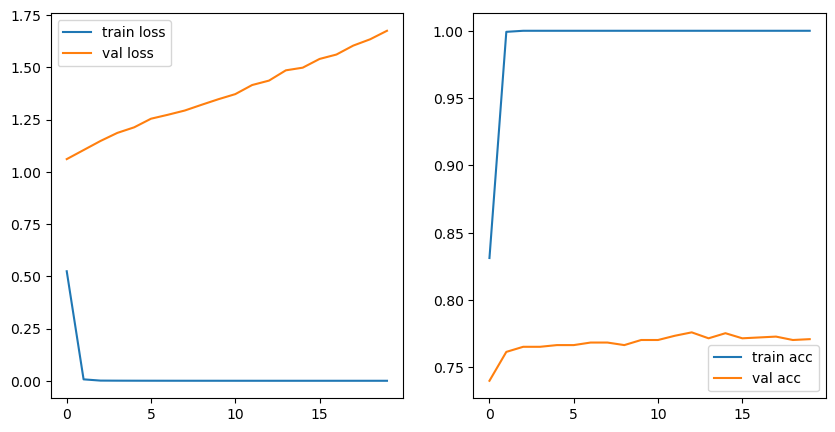

In [55]:
# plot the loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history_MTB, label='train loss')
plt.plot(val_loss_history_MTB, label='val loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_history_MTB, label='train acc')
plt.plot(val_acc_history_MTB, label='val acc')
plt.legend()
plt.show()

**Evaluation**

Use the new dataloader and model to evaluate the new model as in task 5.
> 1. Display: Report, Confusion matrix
> 2. Save: a csv report

Use this format:
> `{student_id_1}_{student_id_n}_part6.csv`
> For example: `300123123_200456789_part_6.csv`


In [72]:
def evaluate_MTB(model, test_dataloader):
  model.eval()
  y_true = []
  y_pred = []
  with torch.no_grad():
    for batch in test_dataloader:
      sentences, labels, index_tuples = batch
      sentences = sentences.to(DEVICE)
      labels = labels.to(DEVICE)
      outputs = model.forward(sentences, index_tuples)
      _, preds = torch.max(outputs, dim=1)
      preds = preds.tolist()
      labels = labels.tolist()
      y_true.extend(labels)
      y_pred.extend(preds)

  return y_pred, y_true   

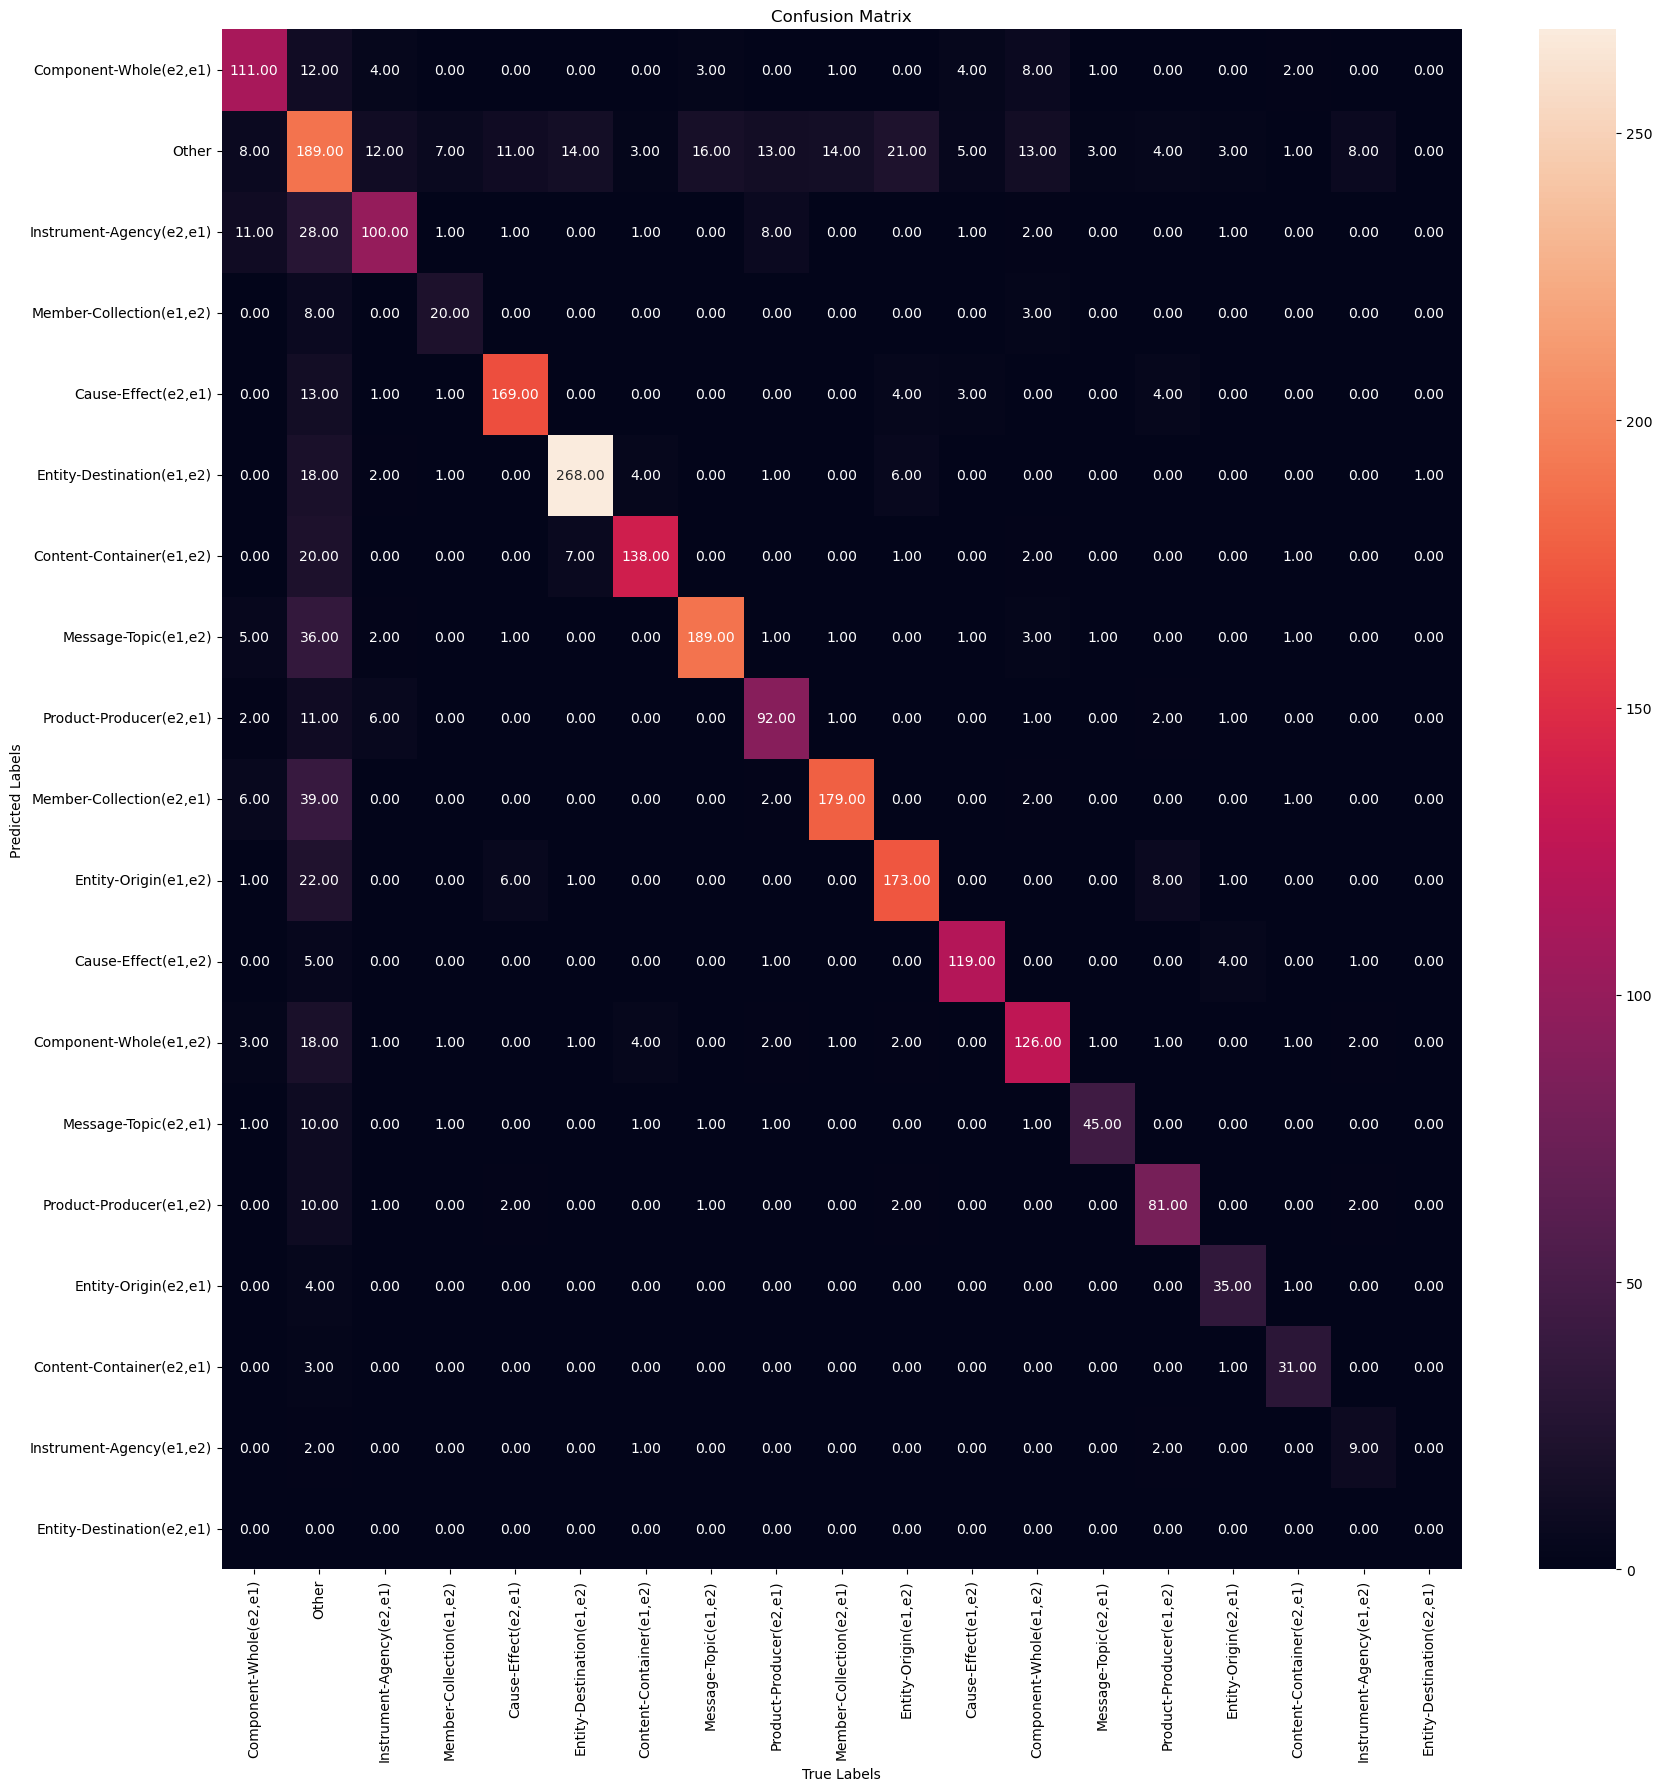

+---------------------------+-------------+----------+------------+
|                           |   precision |   recall |   f1-score |
|---------------------------+-------------+----------+------------|
| Component-Whole(e2,e1)    |    0.760274 | 0.75     |   0.755102 |
| Other                     |    0.547826 | 0.421875 |   0.476671 |
| Instrument-Agency(e2,e1)  |    0.649351 | 0.775194 |   0.706714 |
| Member-Collection(e1,e2)  |    0.645161 | 0.625    |   0.634921 |
| Cause-Effect(e2,e1)       |    0.866667 | 0.889474 |   0.877922 |
| Entity-Destination(e1,e2) |    0.890365 | 0.920962 |   0.905405 |
| Content-Container(e1,e2)  |    0.816568 | 0.907895 |   0.859813 |
| Message-Topic(e1,e2)      |    0.784232 | 0.9      |   0.838137 |
| Product-Producer(e2,e1)   |    0.793103 | 0.760331 |   0.776371 |
| Member-Collection(e2,e1)  |    0.781659 | 0.908629 |   0.840376 |
| Entity-Origin(e1,e2)      |    0.816038 | 0.827751 |   0.821853 |
| Cause-Effect(e1,e2)       |    0.915385 | 0.89

In [76]:
# TO DO

#training(model_part3, n_epochs, train_data, dev_data)
y_pred, y_true = evaluate_MTB(model_MTB, test_dataloader_with_entity_markers)
# convert the label ids to labels
y_pred_str = [id2label_with_entity_markers[id] for id in y_pred]
y_true_str = [id2label_with_entity_markers[id] for id in y_true]

report_MTB = get_report(y_pred_str, y_true_str, list(label2id_with_entity_markers.keys()))
cm_MTB = get_cm_matrix(y_pred_str, y_true_str, list(label2id_with_entity_markers.keys()))

# plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm_MTB, annot=True, fmt='.2f')
plt.title('Confusion Matrix')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

print(tabulate(report_MTB, headers='keys', tablefmt='psql'))

# display()
# save()

<br><br><br><br><br>

## Task 7

In  this final task we will classify similar sentences (1 - similar, 0 - not similar).
We will use an `off the shelf model` and run inference.

- Get the kaggle dataset and create a inference pipeline for the Sentence similarity. Use an off-the-shelf.

Note: you may add change cells as you pleased.


Optional: Clear GPU space if needed

In [ ]:
# TO DO


Set all the relavant random seed to 111

In [ ]:
# TO DO


Download the `train` dataset from [here](https://github.com/saharmilis/runi-nlp/tree/main/kaggle).

In [ ]:
# TO DO


Download the sentence similarty tokenizer & model `all-mpnet-base-v2`.
Here the [link](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) to the model.



In [ ]:
# TO DO


Run inference on the **first 5K lines** in the train dataset, and save it in a dataframe.

In [ ]:
df_t7 = pd.DataFrame(columns=['ID','LABEL_TRUE','LABEL_PRED'])

# TO DO


Print a classification report (use a simple SK-learn classification report)

In [ ]:
# TO DO


Save a CSV file as `{student_id_1}_{student_id_n}_part7.csv` with this format: `ID, LABEL_TRUE, LABEL_PRED`

Notice:
- Do not write the index number to the CSV file.
- Make sure the CSV file will contain only integers.


In [ ]:
# TO DO


<br><br><br><br><br><br>
**Good luck!**